6.4 시계열 데이터 사례분석

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/daily-min-temperatures.csv'
df = pd.read_csv(dataset_filepath)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [3]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [4]:
ts1 = df['Temp']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

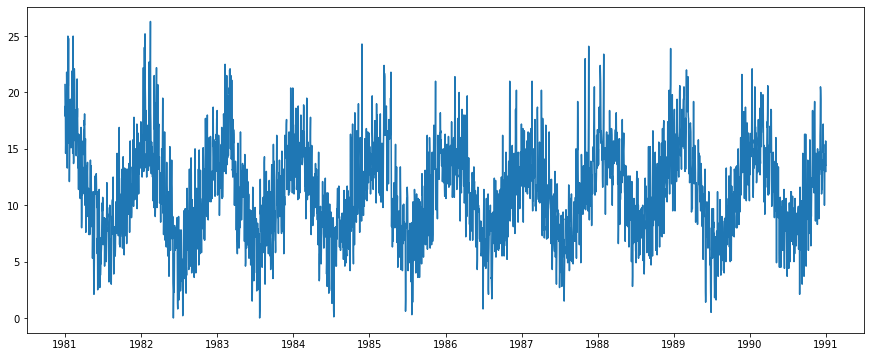

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6 #matlab 차트 기본크기 변경

plt.plot(ts1)

In [6]:
ts1[ts1.isna()]

Series([], Name: Temp, dtype: float64)

In [7]:
ts1=ts1.interpolate(method='time')
ts1[ts1.isna()]

Series([], Name: Temp, dtype: float64)

In [8]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() #이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() #이동표준편차 시계열
    
    #원본시계열, 이동평균, 이동표준편차 plot 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

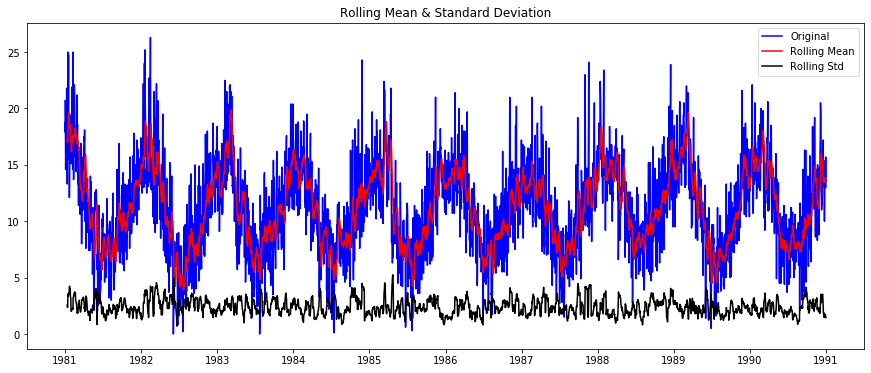

In [9]:
plot_rolling_statistics(ts1, window=12)

다른 데이터셋, International airline passengers 데이터 셋의 패턴을 확인해보자

In [10]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv'
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


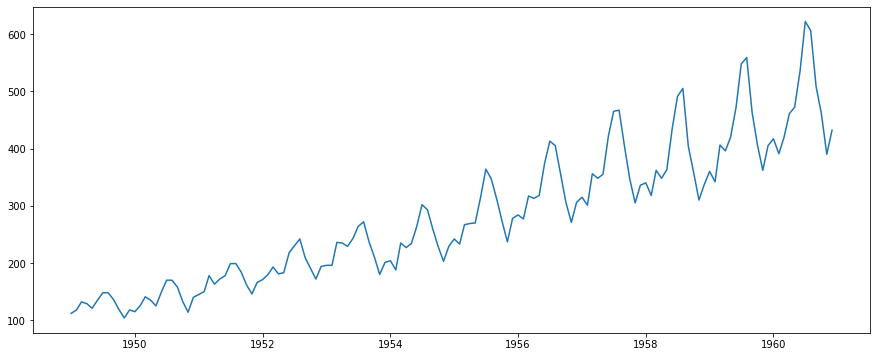

In [11]:
ts2 = df['Passengers']
plt.plot(ts2)

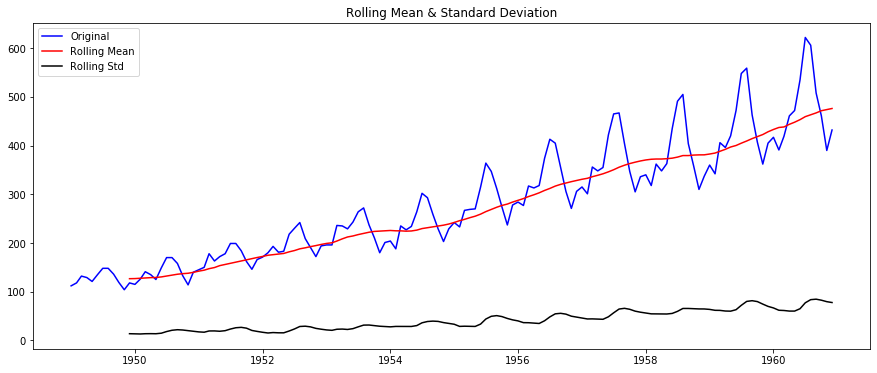

In [12]:
plot_rolling_statistics(ts2, window=12)

6.5 Stationary 여부 체크하는 통계적 방법, 패키지 이용

In [13]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    #statsmodels 패키지에서 제공하는 adfuller 메소드 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
    #adfuller 메소드의 리턴값 정리, 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4],  index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [14]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


p-value 값이 낮으므로 안정적 시계열이라고 판단

In [15]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value 값이 높으므로 안정적 시계열이라고 말할 수 없음

6.6 Stationary하게 데이터 가공하기

시간 추이에 따라 분산이 점점 커지고 있기에, 로그함수로 변환하는 게 도움이 됨

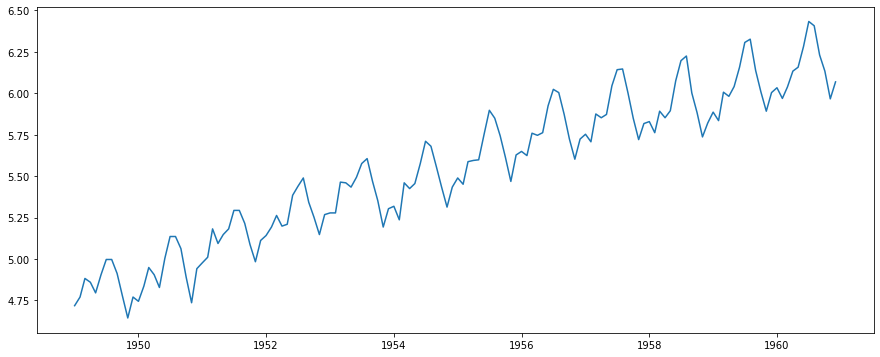

In [16]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [17]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


p-value값 매우 줄어듦

Moving average 제거 - Trend 상쇄하기

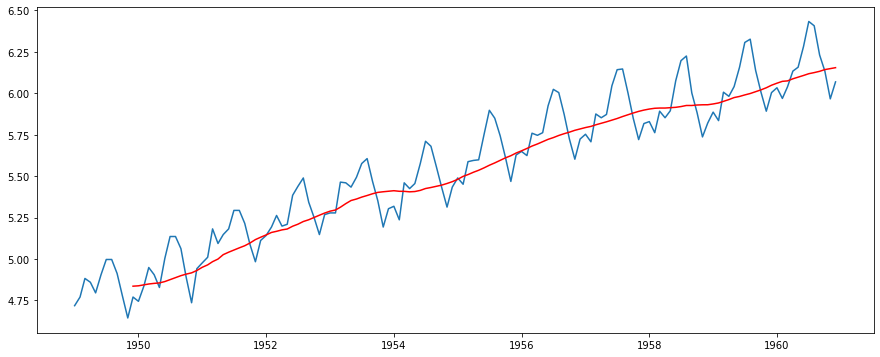

In [18]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [19]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

window = 12 때문에 앞에서 결측치가 발생하여 에러를 내뿜을 것이므로 데이터셋에서 제거시킴

In [20]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

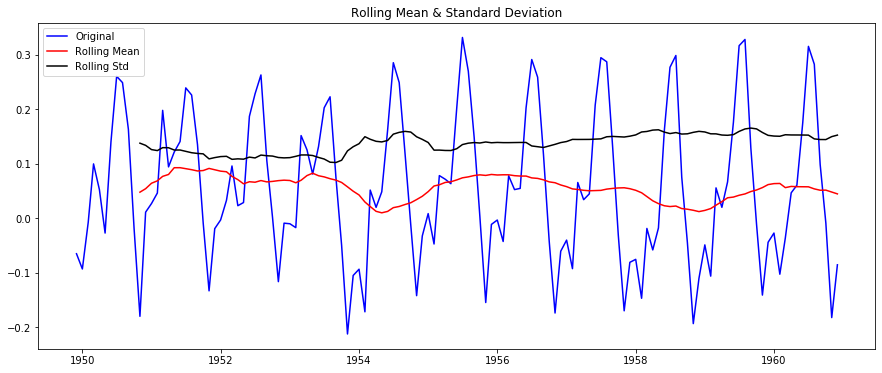

In [21]:
plot_rolling_statistics(ts_log_moving_avg)

In [22]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


만약 window=6을 적용하면 어떻게 됐을까?

In [23]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

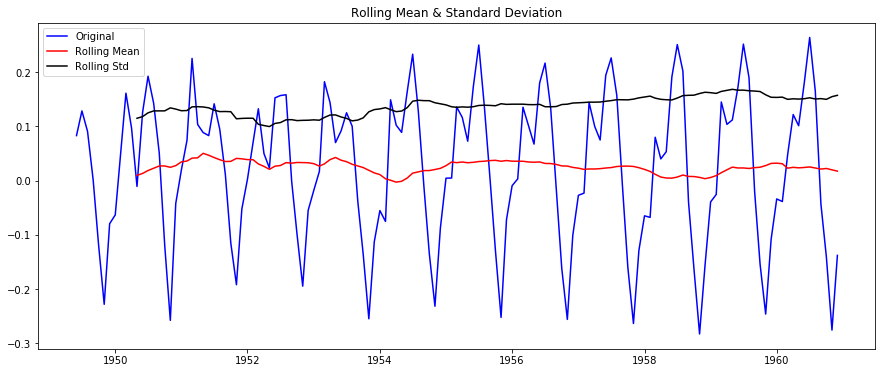

In [24]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [25]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


__Seasonality__ : Moving Average 제거로는 상쇄되지 않는 계절적, 주기적 패턴

차분(Differencing)이라는 개념이 저런 패턴 상쇄하는 데 효과적. 한 스텝 앞으로 시프트한 시계열을 원래 시계열에서 빼 주는 방법

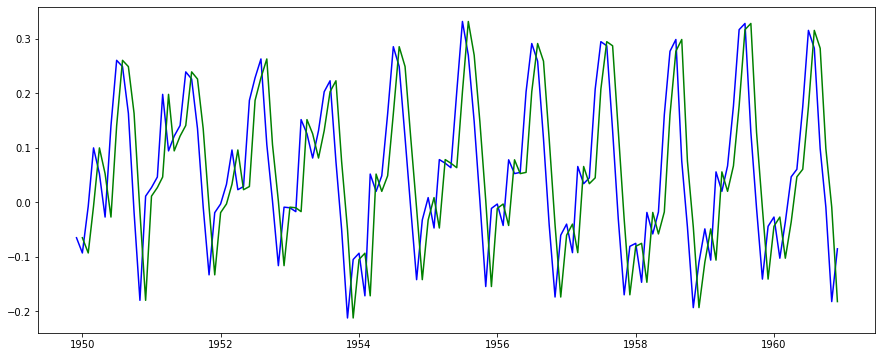

In [26]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

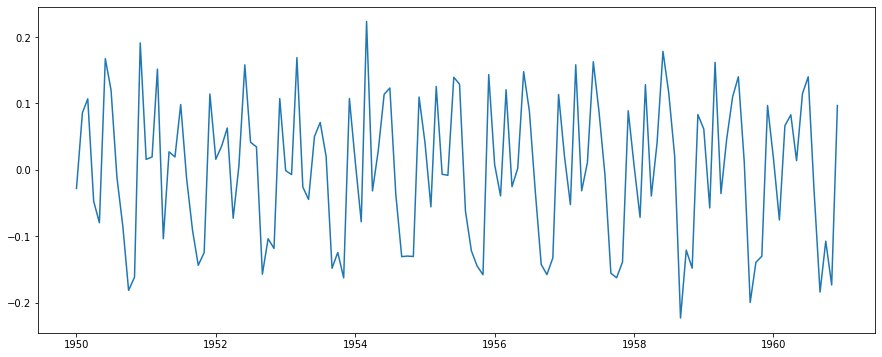

In [27]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

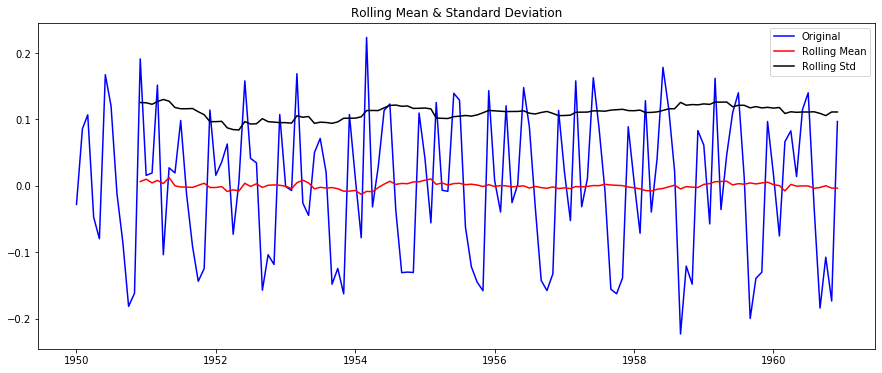

In [28]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [29]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


### 시계열 분해(Time series decomposition)

statsmodels 라이브러리 안 seasonal_decompose 메소드를 통해 trend, seasonality 직접 분리해내기 가능

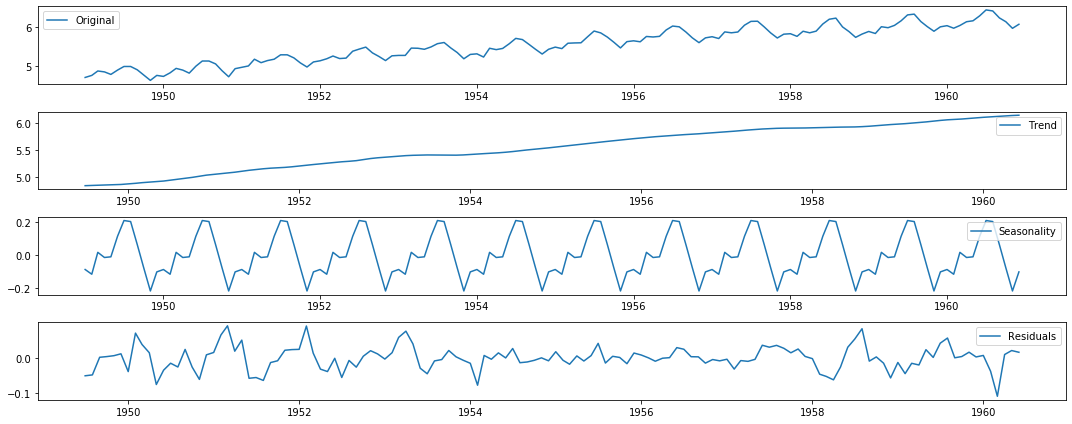

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

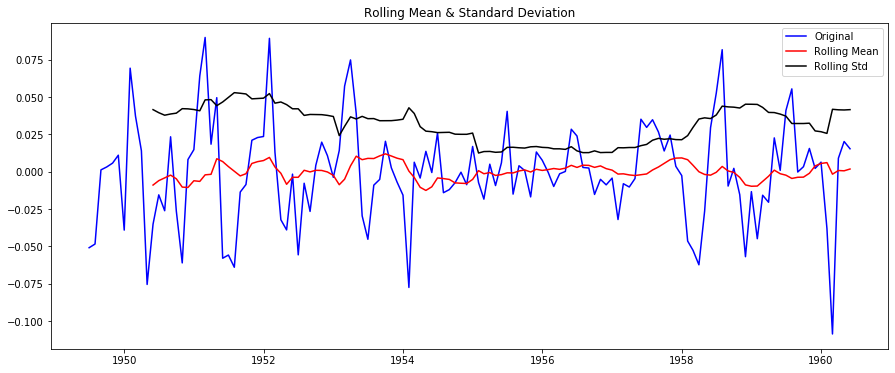

In [31]:
plot_rolling_statistics(residual)

In [32]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


## 6.7 ARIMA 모델의 개념

Autoregressive(자기 회귀) + Integreated(차분누적, Seasonality에 해당) + Moving Average(이동 평균)

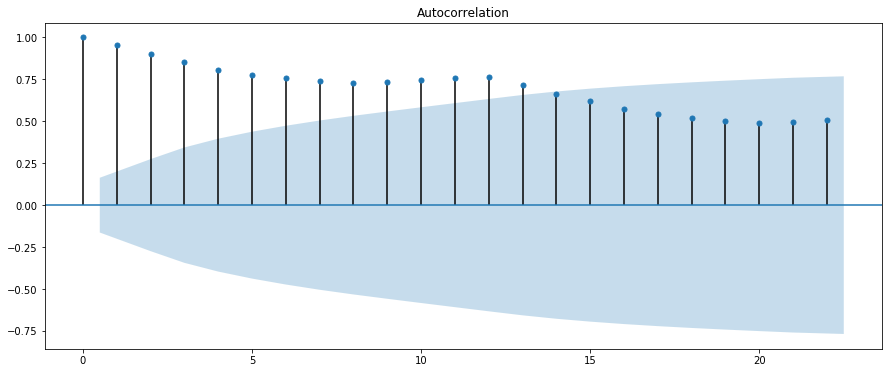

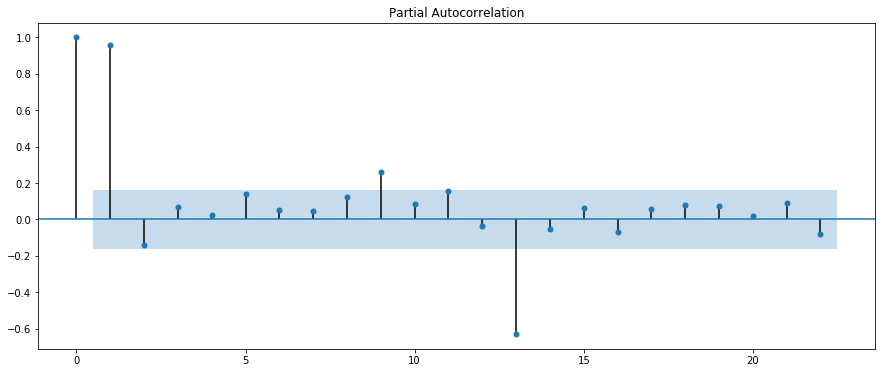

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


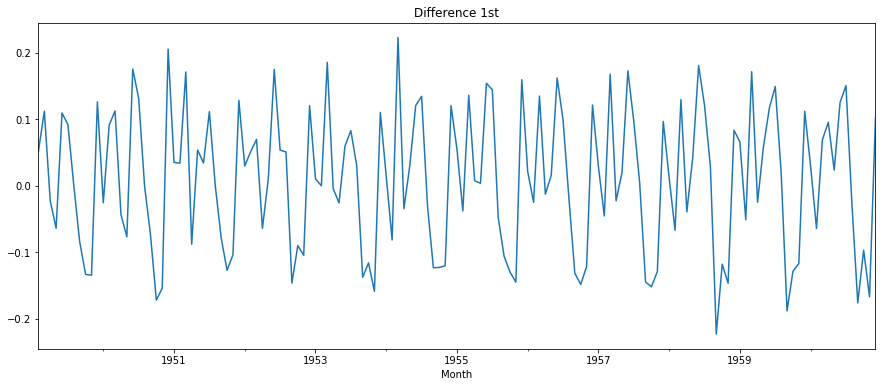

In [34]:
#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


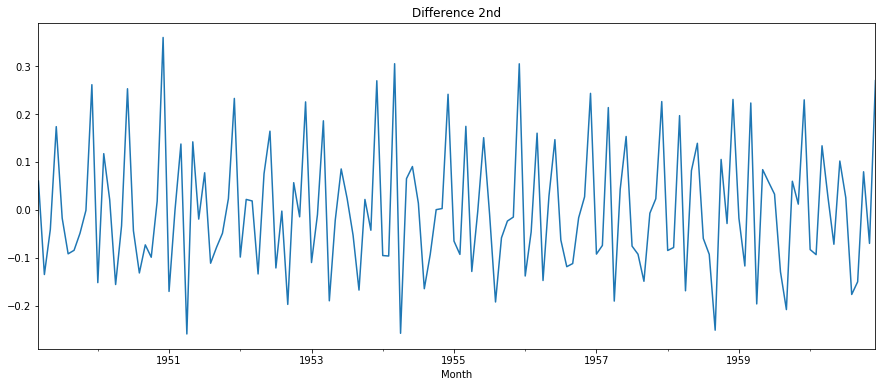

In [35]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

학습데이터 분리. 시계열 예측이므로 가장 나중 데이터를 테스트용으로 사용하는 것이 타당

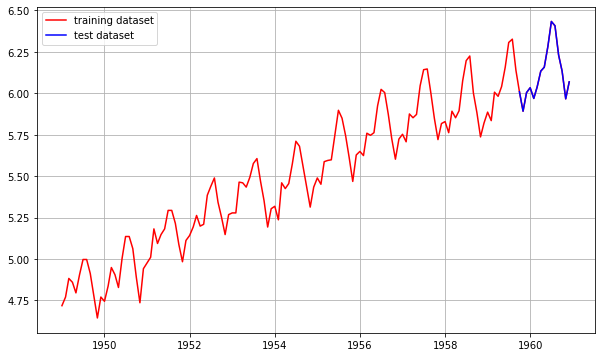

In [36]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [37]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


6.8 ARIMA 모델 훈련과 추론. p=1, d=1, q=0을 모수로 가지는 ARIMA 모델을 우선적으로 고려

In [38]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 108.023
Method:                       css-mle   S.D. of innovations              0.104
Date:                Fri, 21 Aug 2020   AIC                           -210.046
Time:                        14:20:10   BIC                           -201.490
Sample:                    02-01-1949   HQIC                          -206.570
                         - 09-01-1959                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0108      0.011      0.972      0.331      -0.011       0.033
ar.L1.D.Passengers     0.1754      0.088      1.994      0.046       0.003       0.348
                    

/home/aiffel0034/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/aiffel0034/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


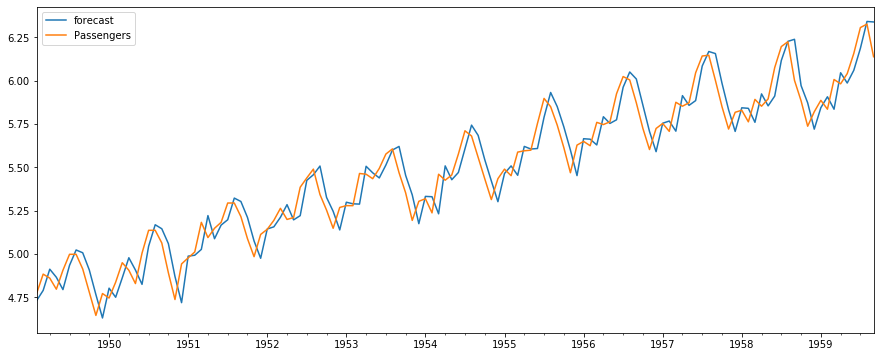

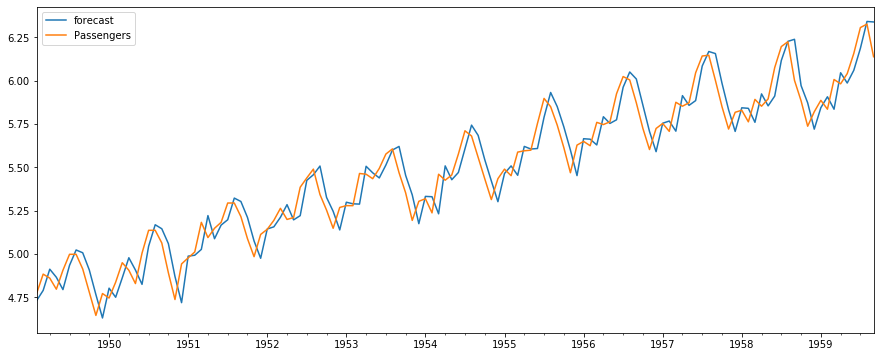

In [39]:
fitted_m.plot_predict()

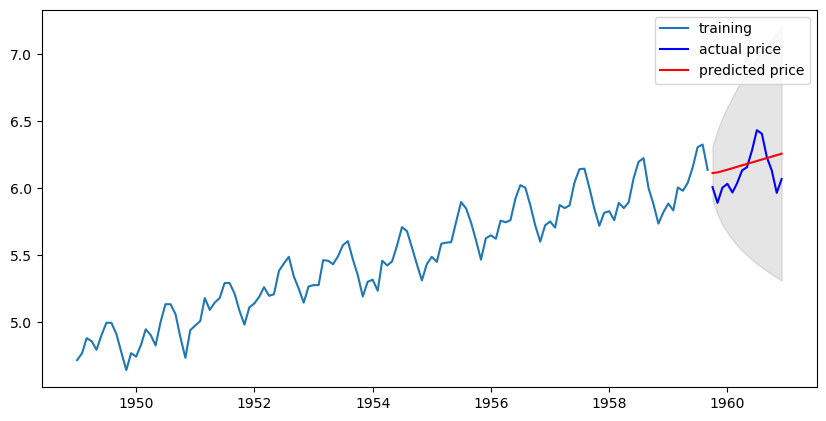

In [40]:
# Forecast : 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index) # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index) # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RSME: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5409.550148511177
MAE:  63.13692396363584
RSME:  73.5496441086643
MAPE: 14.08%
